<a href="https://colab.research.google.com/github/coll-j/Tugas-KK/blob/master/Minggu-9/KKKlasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Category Encoder and download

Target Encoder:
- Documentation: https://contrib.scikit-learn.org/category_encoders/targetencoder.html
- Paper -> https://dl.acm.org/doi/pdf/10.1145/507533.507538

In [2]:
pip install category_encoders

     |████████████████████████████████| 81kB 5.3MB/s 


**Download Data**

In [3]:
!wget https://raw.githubusercontent.com/coll-j/Tugas-KK/master/Minggu-3/data.csv

--2020-11-26 08:22:07--  https://raw.githubusercontent.com/coll-j/Tugas-KK/master/Minggu-3/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.05s   

2020-11-26 08:22:07 (25.7 MB/s) - ‘data.csv’ saved [1475504/1475504]



# Imports

In [5]:
# Utils
import pandas as pd # Dataframe
import numpy as np
import math

# Model related
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.svm import SVC # SVM
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # Ensemble
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from category_encoders.target_encoder import TargetEncoder

# Visualisasi
from sklearn import tree # Visualisasi Decision Tree
import matplotlib.pyplot as plt

# Load Data

**Read data dan assign ke df. Drop kolom `Model` karena tidak akan dipakai**

In [6]:
df = pd.read_csv('data.csv')
df.drop(columns=['Model', 'Market Category'], inplace=True)
df.head()

,Make,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,18,3916,34500


**Men-diskritkan fitur kontinu menggunakan qcut dari pandas dengan parameter `pd.qcut(kolom, jumlah_kelas, label)` dan replace kolom target (MSRP) dengan angka. Kolom yang didiskritkan menjadi 3 kelas antara lain:**

- **Engine HP**
- **highway MPG**
- **city mpg**
- **Popularity**

**Kolom MSRP didiskritkan menjadi 2 kelas murah dan mahal lalu diencode dengan cheap = 0 dan expensive = 1**

In [7]:
df_disc = df.copy()
discretize_features = ['Engine HP', 'highway MPG', 'city mpg', 'Popularity']
for feat in discretize_features:
  df_disc[feat] = pd.qcut(df_disc[feat], 3, labels=['low', 'mid', 'high'])

df_disc['MSRP'] = pd.qcut(df_disc['MSRP'], 2, labels=['cheap', 'expensive'])
df_disc['MSRP'].replace({'cheap': 0, 'expensive': 1}, inplace=True)
df_disc.head()

,Make,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,2011,premium unleaded (required),high,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,mid,mid,high,1
1,BMW,2011,premium unleaded (required),high,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,mid,mid,high,1
2,BMW,2011,premium unleaded (required),high,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,mid,mid,high,1
3,BMW,2011,premium unleaded (required),mid,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,mid,mid,high,0
4,BMW,2011,premium unleaded (required),mid,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,mid,mid,high,1


**Mengganti tipe data semua fitur menjadi `object` dan target menjadi `integer` karena Target Encoder menerima data X (fitur) dalam bentuk object dan y (target) dalam integer**

In [8]:
for col in df_disc.columns:
  df_disc[col] = df_disc[col].astype('object')

df_disc['MSRP'] = df_disc['MSRP'].astype('int')

**Impute tidak dilakukan, maka semua record yang memiliki null values di-drop. Setelah drop menyisakan `11812` data**

In [9]:
df_disc.dropna(inplace=True)
df_disc.describe(include='all')

,Make,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
count,11812,11812.0,11812,11812,11812.0,11812,11812,11812.0,11812,11812,11812,11812,11812,11812.000000
unique,47,28.0,9,3,9.0,5,4,3.0,3,16,3,3,3,NaN
top,Chevrolet,2015.0,regular unleaded,low,4.0,AUTOMATIC,front wheel drive,4.0,Compact,Sedan,low,mid,mid,NaN
freq,1115,2152.0,7155,4035,4743.0,8231,4732,8263.0,4708,3013,4290,4488,4446,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496952
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500012
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


# Encoding

Model menerima input target dalam bentuk numerik, sedangkan fitur yang dimiliki bertipe object dan beberapa berupa string sehingga perlu diencode agar menjadi angka. Ada beberapa jenis encoding diantaranya yang paling umum:
- One hot Encoding
<br>mengubah kelas pada kolom kategorik menjadi kolom. dengan label 1 pada kolom kelas yang sesuai. <br> contoh: sebuah kolom kategorik 'A' memiliki unique value 'a', 'b', 'c' untuk data:

> idx | A
> --- | ---
> 0 | a
> 1 | a
> 2 | c
> 3 | b

akan menjadi:
> idx | A_a | A_b | A_c
> --- | --- | --- | ---
> 0 | 1 | 0 | 0 
> 1 | 1 | 0 | 0
> 2 | 0 | 0 | 1
> 3 | 0 | 1 | 0

Drawback: jika kelas ada banyak, kolom menjadi tambah banyak

- Ordinal Encoding
<br>melabel unique value pada kelas ke sebuah integer dengan range 0 sampai jumlah kelas-1. <br> contoh dengan data sebelum akan menjadi:

> idx | A
> --- | ---
> 0 | 0
> 1 | 0
> 2 | 2
> 3 | 1

Drawback: Pada realitanya, value 'b' pada kolom A belum tentu lebih baik dari value 'a'. Hal ini dapat mempengaruhi pembelajaran model.

Jalan lain menggunakan **Target Encoder** yang meng-encode berdasarkan target. Value yang diberikan antara 0 sampai 1

In [10]:
te = TargetEncoder()

In [11]:
y = df_disc['MSRP'].values
X = df_disc.drop(columns=['MSRP']).values
te.fit(X, df_disc['MSRP'].values)
X = te.transform(X)

X.head()
# X.loc[17, :]
# print(X)
# print(y)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.967066,0.578571,0.922652,0.920510,0.603803,0.224504,0.614786,0.455295,0.275913,0.612605,0.577674,0.583556,0.555456
1,0.967066,0.578571,0.922652,0.920510,0.603803,0.224504,0.614786,0.455295,0.275913,0.742749,0.577674,0.583556,0.555456
2,0.967066,0.578571,0.922652,0.920510,0.603803,0.224504,0.614786,0.455295,0.275913,0.612605,0.577674,0.583556,0.555456
3,0.967066,0.578571,0.922652,0.530893,0.603803,0.224504,0.614786,0.455295,0.275913,0.612605,0.577674,0.583556,0.555456
4,0.967066,0.578571,0.922652,0.530893,0.603803,0.224504,0.614786,0.455295,0.275913,0.742749,0.577674,0.583556,0.555456


**Bisa dilihat pada kolom ber-index 3 yaitu Engine HP, value high pada Engine HP di-encode menjadi 0.92051 dan medium menjadi 0.530893. Hal ini sejalan dengan fakta bahwa mobil dengan HP lebih tinggi memiliki harga lebih tinggi juga sehingga value high lebih besar dari medium**

# Training

**Dalam proses training dicoba dengan beberapa ukuran training yang ditentukan oleh ukuran data testing.**

> jumlah data training = jumlah keseluruhan data - jumlah data testing

**Jumlah data testing direpresentasikan dalam presentase sehingga jika di-tablekan menjadi:**

> testing | training
> --- | ---
> 0.6 | 0.4
> 0.5 | 0.5
> 0.4 | 0.6
> 0.3 | 0.7

**Alur percobaan dilakukan dengan looping setiap parameter model:**
1. Inisiasi model
2. Fitting model terhadap data training
3. Prediksi model terhadap data testing
4. Perhitungan akurasi dan f1 terhadap data testing
5. Pemilihan parameter terbaik sesuai akurasi dari data testing

## Decision Tree

**Penentuan parameter pada Decision Tree**
- max_depth: kedalaman pohon yang dibangun
- criterion: perhitungan untuk penentuan node pada pohon

In [12]:
param_dt = {
    'test_size': [0.6, 0.5, 0.4, 0.3],
    'max_depth': [None, 3, 5, 7],
    'criterion': ['gini', 'entropy']
}

In [13]:
row_format ="{:>10}" * (len(param_dt) + 2)
print(row_format.format('t_size', 'max_depth', 'criterion', 'akurasi', 'f1'))
acc_bfr = -math.inf
for i in param_dt['test_size']:
  for j in param_dt['max_depth']:
    for k in param_dt['criterion']:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
      dt = DecisionTreeClassifier(random_state=42, max_depth=j, criterion=k)
      dt.fit(X_train, y_train) # fitting

      pred = dt.predict(X_test) # prediksi data testing
      acc = metrics.accuracy_score(y_test, pred) # akurasi prediksi data testing
      f1 = metrics.f1_score(y_test, pred) # f1 prediksi data testing
      if(acc > acc_bfr):
        acc_bfr = acc
        best_param_dt = {'t_size': i, 'max_depth': j, 'criterion': k, 'accuracy': acc, 'f1': f1}
        best_dt = dt
      print(row_format.format(str(i), str(j), str(k), '%.3f' % acc, '%.3f' % f1))
print('best param: ', best_param_dt)     

    t_size max_depth criterion   akurasi        f1
       0.6      None      gini     0.916     0.913
       0.6      None   entropy     0.919     0.916
       0.6         3      gini     0.868     0.858
       0.6         3   entropy     0.851     0.850
       0.6         5      gini     0.902     0.899
       0.6         5   entropy     0.900     0.897
       0.6         7      gini     0.921     0.918
       0.6         7   entropy     0.912     0.910
       0.5      None      gini     0.919     0.917
       0.5      None   entropy     0.918     0.915
       0.5         3      gini     0.874     0.877
       0.5         3   entropy     0.853     0.852
       0.5         5      gini     0.902     0.900
       0.5         5   entropy     0.893     0.890
       0.5         7      gini     0.919     0.916
       0.5         7   entropy     0.911     0.908
       0.4      None      gini     0.917     0.915
       0.4      None   entropy     0.915     0.913
       0.4         3      gini 

**Visualisasi pohon dari parameter terbaik**

### Visualisasi Text

In [15]:
text_representation = tree.export_text(best_dt)
print(text_representation)

|--- feature_3 <= 0.29
|   |--- feature_0 <= 0.96
|   |   |--- feature_6 <= 0.69
|   |   |   |--- feature_5 <= 0.66
|   |   |   |   |--- feature_9 <= 0.64
|   |   |   |   |   |--- feature_0 <= 0.92
|   |   |   |   |   |   |--- feature_5 <= 0.35
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_5 >  0.35
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  0.92
|   |   |   |   |   |   |--- feature_0 <= 0.94
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_0 >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_9 >  0.64
|   |   |   |   |   |--- feature_10 <= 0.45
|   |   |   |   |   |   |--- feature_0 <= 0.28
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_0 >  0.28
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_10 >  0.45
|   |   |   |   |   |   |--- feature_1 <= 0.64
|   |   |   |   |   |   |   |--- class: 0
|   |   |

### Visualisasi Graph

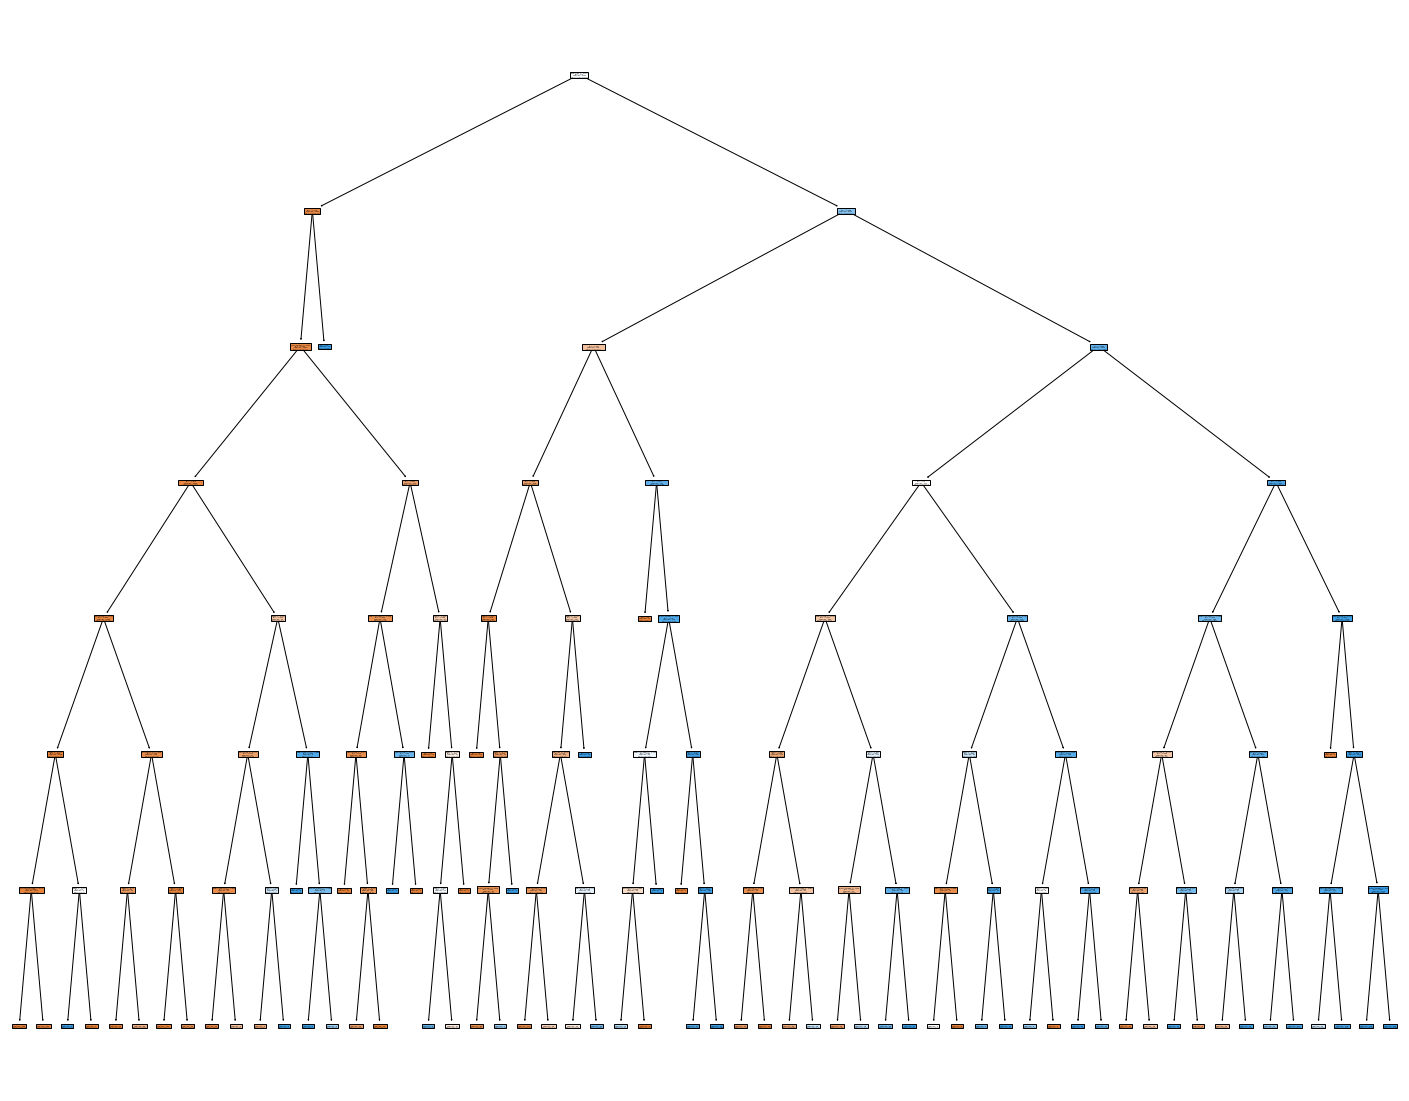

In [14]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=df.drop(columns=['MSRP']).columns,  
                   filled=True)

## SVM

**Penentuan parameter pada SVM:**
- C: nilai regularisasi
- gamma: koefisien kernel untuk poly, rbf, dan sigmoid
- kernel: metode untuk perubahan dimensi

In [16]:
param_svm = {
  'test_size': [0.6, 0.5, 0.4, 0.3],  
  'C'    : [1, 10, 100, 0.1],
  'gamma': [0.1, 0.01, 0.001, 1.0],
  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

In [17]:
row_format ="{:>10}" * (len(param_svm) + 2)
print(row_format.format(*param_svm, 'akurasi', 'f1'))
acc_bfr = -math.inf
for i in param_svm['test_size']:
  for j in param_svm['C']:
    for k in param_svm['gamma']:
      for l in param_svm['kernel']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
        svc = SVC(C=j, gamma=k, kernel=l)
        svc.fit(X_train, y_train)

        # print(y_test)
        pred = svc.predict(X_test)
        acc = metrics.accuracy_score(y_test, pred)
        f1 = metrics.f1_score(y_test, pred)
        if(acc > acc_bfr):
          acc_bfr = acc
          best_param_svm = {'t_size': i, 'C': j, 'gamma': k, 'kernel': l, 'accuracy': acc, 'f1': f1}
        print(row_format.format(str(i), str(j), str(k), str(l), '%.3f' % acc, '%.3f' % f1))
print('best param: ', best_param_svm)     

 test_size         C     gamma    kernel   akurasi        f1
       0.6         1       0.1    linear     0.912     0.910
       0.6         1       0.1      poly     0.903     0.899
       0.6         1       0.1       rbf     0.914     0.912
       0.6         1       0.1   sigmoid     0.912     0.911
       0.6         1      0.01    linear     0.912     0.910
       0.6         1      0.01      poly     0.491     0.659
       0.6         1      0.01       rbf     0.907     0.906
       0.6         1      0.01   sigmoid     0.903     0.901
       0.6         1     0.001    linear     0.912     0.910
       0.6         1     0.001      poly     0.491     0.659
       0.6         1     0.001       rbf     0.887     0.885
       0.6         1     0.001   sigmoid     0.882     0.878
       0.6         1       1.0    linear     0.912     0.910
       0.6         1       1.0      poly     0.919     0.916
       0.6         1       1.0       rbf     0.917     0.915
       0.6         1    

## KNN

**Penentuan parameter KNN**
- n_neighbors: jumlah neighbor untuk klasifikasi
- weights: weight untuk neighbor, dimana ketika di-set uniform semua neighbor memiliki weight yang sama dan distance dihitung berdasarkan jarak dengan query point
- algorithm: algoritma untuk menghitung neighbor terdekat

In [18]:
param_knn = {
  'test_size': [0.6, 0.5, 0.4, 0.3],  
  'n_neighbor': [3, 5, 7],
  'weights': ['uniform', 'distance'],
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [19]:
row_format ="{:>10}" * (len(param_knn) + 2)
print(row_format.format(*param_knn, 'akurasi', 'f1'))
acc_bfr = -math.inf
for i in param_knn['test_size']:
  for j in param_knn['n_neighbor']:
    for k in param_knn['weights']:
      for l in param_knn['algorithm']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=j, weights=k, algorithm=l)
        knn.fit(X_train, y_train)

        # print(y_test)
        pred = knn.predict(X_test)
        acc = metrics.accuracy_score(y_test, pred)
        f1 = metrics.f1_score(y_test, pred)
        if(acc > acc_bfr):
          acc_bfr = acc
          best_param_knn = {'t_size': i, 'n_beighbors': j, 'weights': k, 'algorithm': l, 'accuracy': acc, 'f1': f1}
        print(row_format.format(str(i), str(j), str(k), str(l), '%.3f' % acc, '%.3f' % f1))
print('best param: ', best_param_knn)     

 test_sizen_neighbor   weights algorithm   akurasi        f1
       0.6         3   uniform      auto     0.922     0.920
       0.6         3   uniform ball_tree     0.922     0.920
       0.6         3   uniform   kd_tree     0.922     0.920
       0.6         3   uniform     brute     0.921     0.919
       0.6         3  distance      auto     0.921     0.919
       0.6         3  distance ball_tree     0.921     0.919
       0.6         3  distance   kd_tree     0.921     0.919
       0.6         3  distance     brute     0.923     0.921
       0.6         5   uniform      auto     0.920     0.918
       0.6         5   uniform ball_tree     0.920     0.918
       0.6         5   uniform   kd_tree     0.920     0.918
       0.6         5   uniform     brute     0.921     0.919
       0.6         5  distance      auto     0.923     0.921
       0.6         5  distance ball_tree     0.923     0.921
       0.6         5  distance   kd_tree     0.923     0.921
       0.6         5  di

## Random Forest

**Random Forest merupakan ensemble dengan base Decision Tree. Parameter yang ditentukan kurang lebih sama dengan Decision Tree dengan tambahan `n_estimators` yang merupakan jumlah Decision Tree yang digunakan**


In [22]:
param_rf = {
    'test_size': [0.6, 0.5, 0.4, 0.3],
    'max_depth': [None, 7, 10],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 10, 50]
}

In [23]:
row_format ="{:>10}" * (len(param_rf) + 2)
print(row_format.format(*param_rf, 'akurasi', 'f1'))
acc_bfr = -math.inf
for i in param_rf['test_size']:
  for j in param_rf['max_depth']:
    for k in param_rf['criterion']:
      for l in param_rf['n_estimators']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
        rf = RandomForestClassifier(random_state=42, max_depth=j, criterion=k, n_estimators=l)
        rf.fit(X_train, y_train)

        # print(y_test)
        pred = rf.predict(X_test)
        acc = metrics.accuracy_score(y_test, pred)
        f1 = metrics.f1_score(y_test, pred)
        if(acc > acc_bfr):
          acc_bfr = acc
          best_param_rf = {'t_size': i, 'max_depth': j, 'criterion': k, 'n_estimator': l, 'accuracy': acc, 'f1': f1}
        print(row_format.format(str(i), str(j), str(k), str(l), '%.3f' % acc, '%.3f' % f1))
print('best param: ', best_param_rf)     

 test_size max_depth criterionn_estimators   akurasi        f1
       0.6      None      gini       100     0.923     0.921
       0.6      None      gini       200     0.923     0.922
       0.6      None      gini        10     0.918     0.916
       0.6      None      gini        50     0.923     0.922
       0.6      None   entropy       100     0.923     0.922
       0.6      None   entropy       200     0.925     0.923
       0.6      None   entropy        10     0.919     0.917
       0.6      None   entropy        50     0.924     0.923
       0.6         7      gini       100     0.923     0.921
       0.6         7      gini       200     0.923     0.921
       0.6         7      gini        10     0.918     0.917
       0.6         7      gini        50     0.922     0.920
       0.6         7   entropy       100     0.921     0.919
       0.6         7   entropy       200     0.920     0.918
       0.6         7   entropy        10     0.918     0.916
       0.6         7  

## Voting

**Dalam voting kami tidak mencoba hyperparameter tuning. Hanya base model yang kami gunakan adalah model-model sebelumnya dengan parameter terbaik sesuai nilai akurasi**

In [24]:
param_voting = {
    'test_size': [0.6, 0.5, 0.4, 0.3]
}

In [25]:
row_format ="{:>10}" * (len(param_voting) + 2)
print(row_format.format(*param_voting, 'akurasi', 'f1'))
acc_bfr = -math.inf
for i in param_voting['test_size']:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)
  voting = VotingClassifier(estimators=[
          ('svm', SVC(C=best_param_svm['C'], gamma=best_param_svm['gamma'], kernel=best_param_svm['kernel'])),
          ('knn', KNeighborsClassifier(n_neighbors=best_param_knn['n_beighbors'], weights=best_param_knn['weights'], algorithm=best_param_knn['algorithm'])),
          ('rf', RandomForestClassifier(n_estimators=best_param_rf['n_estimator'], criterion=best_param_rf['criterion'], max_depth=best_param_rf['max_depth']))])
  voting.fit(X_train, y_train)

  # print(y_test)
  pred = voting.predict(X_test)
  acc = metrics.accuracy_score(y_test, pred)
  f1 = metrics.f1_score(y_test, pred)
  if(acc > acc_bfr):
    acc_bfr = acc
    best_param_voting = {'t_size': i, 'accuracy': acc, 'f1': f1}
  print(row_format.format(str(i), '%.3f' % acc, '%.3f' % f1))
print('best param: ', best_param_voting)     

 test_size   akurasi        f1
       0.6     0.927     0.925
       0.5     0.930     0.929
       0.4     0.928     0.926
       0.3     0.927     0.925
best param:  {'t_size': 0.5, 'accuracy': 0.9302404334575008, 'f1': 0.9285961871750433}
